In [68]:
import pandas as pd
import numpy as npD
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from seaborn import histplot
import math
import spacy
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer,TreebankWordTokenizer
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tag import StanfordPOSTagger
from data_process import remove_textNoise,get_tokenize,get_pos_tag,lemmatize_word
from nltk.stem.wordnet import WordNetLemmatizer
from data_process import en_stopwords,replace_locName,detect_link,has_money, load_NltkModel
import multiprocessing as mp

In [69]:
#set Java enviroment variable
os.environ['JRE_HOME']=r'C:/Program Files/Java/jre1.8.0_241/bin/java.exe'
spacy.require_gpu(0)
pd.set_option('display.max_columns',None)
#read data
data_dir=r'D:\acer\Desktop\ORF_Detect\Data\fakejob'
mode='train'
data_path='data.csv'
df=pd.read_csv(os.path.join(data_dir,mode,data_path),encoding='utf_8_sig')
#build tokenizer
tb_tokenizer=TreebankWordTokenizer()
tbd_tokenizer=TreebankWordDetokenizer()
#loading nlp package
en_nlp=spacy.load('en_core_web_md')
htmlCol_names=['company_profile','description','requirements','benefits']

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               14304 non-null  int64 
 1   title                14304 non-null  object
 2   location             14038 non-null  object
 3   department           5049 non-null   object
 4   salary_range         2310 non-null   object
 5   company_profile      11638 non-null  object
 6   description          14303 non-null  object
 7   requirements         12139 non-null  object
 8   benefits             8529 non-null   object
 9   telecommuting        14304 non-null  int64 
 10  has_company_logo     14304 non-null  int64 
 11  has_questions        14304 non-null  int64 
 12  employment_type      11531 non-null  object
 13  required_experience  8676 non-null   object
 14  required_education   7862 non-null   object
 15  industry             10381 non-null  object
 16  func

In [70]:
#remove duplicate data based on Job description
print('Before remove duplicat data shape:',df.shape)
df=df.drop_duplicates(subset=['description','title'],keep=False).reset_index(drop=True)
print('after remove duplicated data shape:',df.shape)
print(df.head(100))
print(df.reset_index().head(100))
#查看對於fraud & legtimate company profile 的empty數量
print('------legtimate exmaples info------------')
print(df.loc[df.fraudulent==0].info())
print('------Fruad exmaples info------------')
print(df.loc[df.fraudulent==1].info())

Before remove duplicat data shape: (14304, 18)
after remove duplicated data shape: (12176, 18)
    job_id                                              title  \
0     8915                            Front End Web Developer   
1     3404                           Technical/Resume Writer    
2    10929  Vice President - PMO (provides relocation assi...   
3    11752                                      PHP Developer   
4      568                     Technical Site Representative    
..     ...                                                ...   
95    7013                                      PHP Developer   
96    7122                      WEB DEVELOPER with Angular.JS   
97    7691                         Sales & Leads Professional   
98    5820                               Game Studio Manager    
99   11974  ASP.net Developer Job opportunity at United St...   

               location   department   salary_range  \
0   US, KS, Kansas City          NaN    70000-90000   
1             

In [71]:
#display duplicate text in text columns
def count_duplicateData(df_data,col_name,labels):
    print(f'--------------display duplicate data in {col_name}---------------')
    #filter dupicated data in columns 
    duplicated_data=df_data.loc[df_data[col_name].duplicated(keep=False),col_name].copy().dropna()
    duplicated_data=df_data.loc[duplicated_data.index]

    print('total duplicated data num:{}'.format(len(duplicated_data)))

    return duplicated_data.index

In [72]:
#查看個類別欄位空值的數量
legitDf=df.loc[df.fraudulent==0,:].copy()
FraudDf=df.loc[df.fraudulent==1,:].copy()
null_legitDf=legitDf.isna()
null_FraudDf=FraudDf.isna()

print('-----Origin blank field in each column----')
for c_name in htmlCol_names:
    print(f'{c_name} fraud &legit number')
    print(f'legit propotion:{sum(null_legitDf[c_name])/len(legitDf)} \t Fraud num:{sum(null_FraudDf[c_name])/len(FraudDf)}')

-----Origin blank field in each column----
company_profile fraud &legit number
legit propotion:0.17565485362095531 	 Fraud num:0.708502024291498
description fraud &legit number
legit propotion:0.0 	 Fraud num:0.0020242914979757085
requirements fraud &legit number
legit propotion:0.13910289334018147 	 Fraud num:0.20242914979757085
benefits fraud &legit number
legit propotion:0.4159390515322719 	 Fraud num:0.46558704453441296


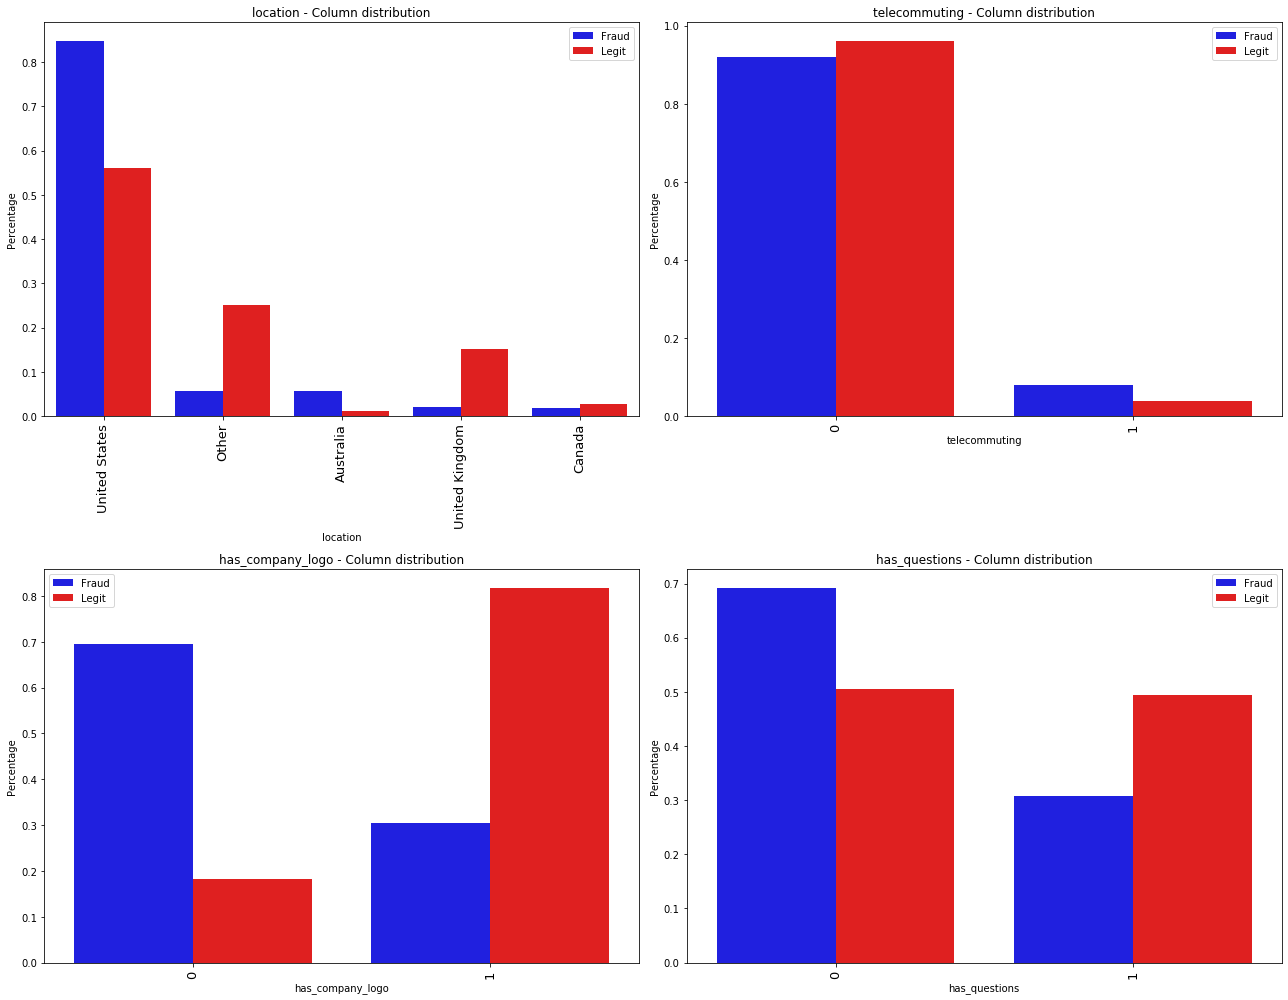

In [73]:
'''Explore Categorical data (Company logo,telecomuting,company_logo,question,location)distribution'''
def plot_percent(group_df,col_names):
    fig=plt.figure(figsize=(18,14))
    #compute row nums
    nrows=math.ceil(len(col_names)/2)
    for idx,name in enumerate(col_names):
        
        #compute group percentage
        counts=group_df[name].value_counts(normalize=True,dropna=True).rename('percentage').reset_index()

        #plot percentage
        ax=fig.add_subplot(nrows,2,idx+1)
        p=sns.barplot(x=name,y='percentage',hue='label_names',data=counts,ax=ax,palette={'Fraud':'b','Legit':'r'})
        plt.setp(p.get_xticklabels(),rotation=90,fontsize=13)
        ax.set_title(f'{name} - Column distribution')
        ax.set_ylabel('Percentage')
        ax.legend()
    fig.tight_layout()
    plt.show()
#change label name
Id2Label={1:'Fraud',0:'Legit'}
df['label_names']=df['fraudulent'].apply(lambda x:Id2Label[x])
df.fillna(value={'company_profile':'','description':'','requirements':'','benefits':''},inplace=True)
#change country names
df['location']=df['location'].dropna().apply(lambda x: replace_locName(x))
#detect column whether has link
for c_name in htmlCol_names:
    df[c_name+'_has_link']=df[c_name].apply(lambda x:detect_link(x))
#detect title whether has money
df['title_has_money']=df['title'].apply(lambda x:has_money(x))
#Grouped data
group_df=df.groupby(['label_names'])
plot_percent(group_df,['location','telecommuting','has_company_logo','has_questions'])


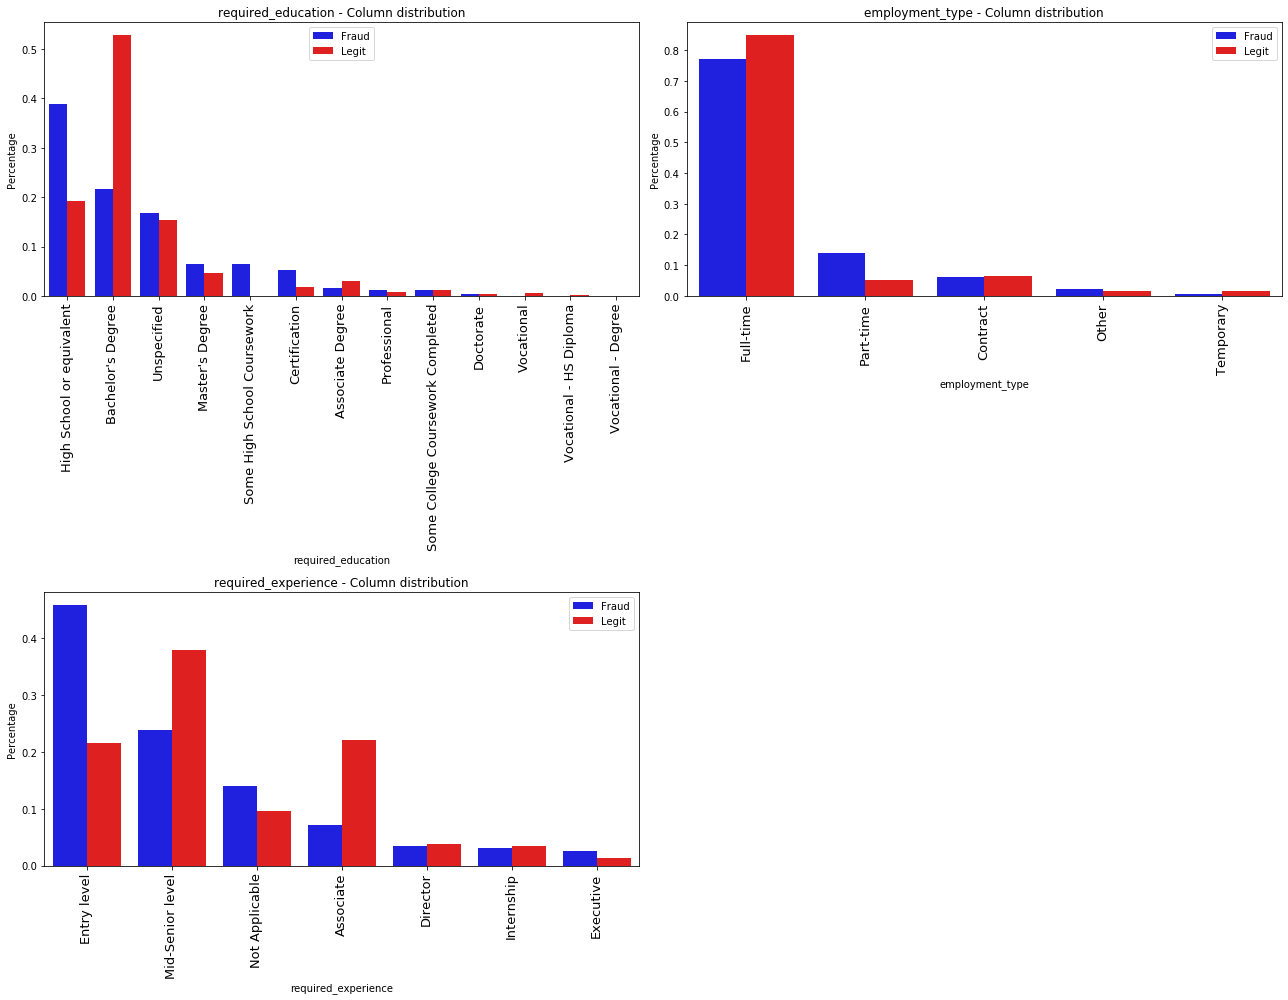

In [74]:
plot_percent(group_df,['required_education','employment_type','required_experience'])

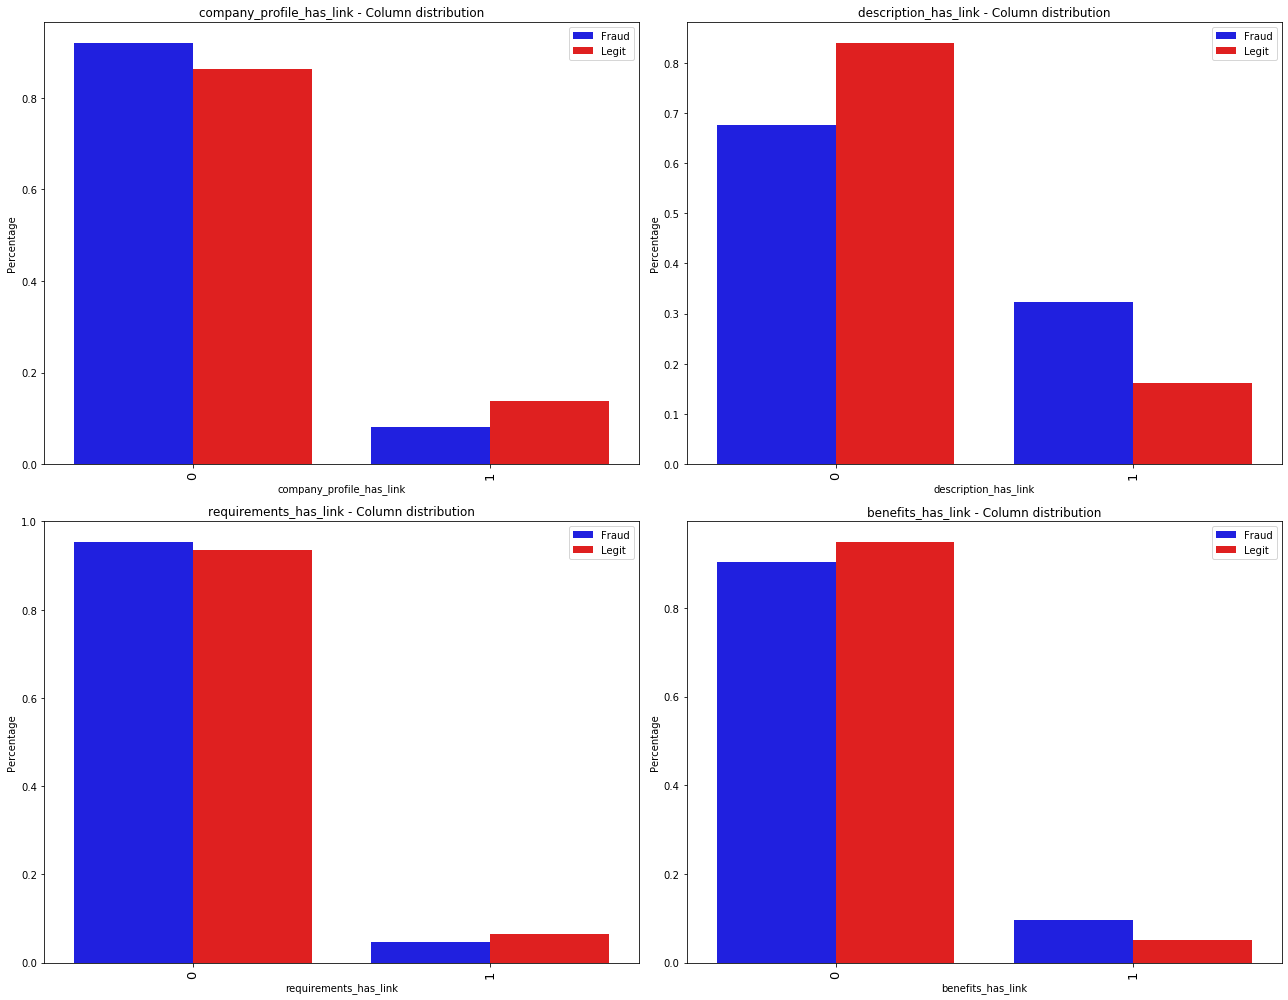

In [75]:
plot_percent(group_df,['company_profile_has_link','description_has_link','requirements_has_link','benefits_has_link'])

label_names  title_has_money
Fraud        0                  0.981781
             1                  0.018219
Legit        0                  0.996576
             1                  0.003424
Name: title_has_money, dtype: float64


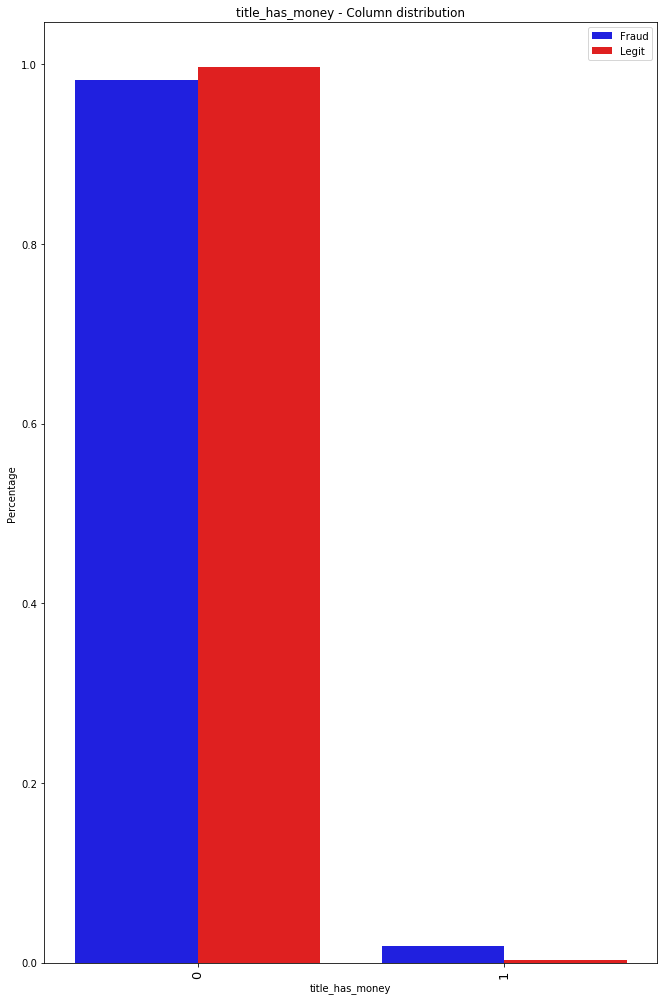

In [76]:
print(group_df['title_has_money'].value_counts(normalize=True,dropna=True))
plot_percent(group_df,['title_has_money'])

In [77]:
'''exploratory data info. for 4 columns(company profile,desrciption,requirement,benefit)'''
def create_x(dfs,column_names,axis=1):
    x_Data=[]
    for c_name in column_names:
        #storage fraud &legti data
        combined_data=[df.loc[:,c_name].values for df in dfs]
        x_Data.append(combined_data)
    return x_Data
'''Exploratory html string data'''
#select specific column
df_text=df.select_dtypes(include='object')
#remain html tag column (company_profile,description,requirement,benefits)
df_text=df_text.drop([c_name for c_name in df_text.columns if c_name not in htmlCol_names],axis=1)
#combine label data
df_text=pd.concat([df_text,df['label_names'].copy()],axis=1)
#fill nan value
df_text=df_text.fillna('')
#text process in text columns
for col in htmlCol_names:
    df_text[col+'_clean']=df_text[col].apply(lambda x:remove_textNoise(x))
#compute empty and non-empty info propotion on each target class
for name in ['company_profile','requirements','benefits']:
    #segmentation text
    df_text[name+'_doc']=df_text[name+'_clean'].apply(lambda x:en_nlp(x) if x else '')

In [81]:
#segmentation text
with en_nlp.disable_pipes('ner'):
    df_text.loc[:6176,'description_doc']=df_text.loc[:6176,'description_clean'].apply(lambda x:en_nlp(x) if x else '')

OutOfMemoryError: Out of memory allocating 2,084,864 bytes (allocated so far: 1,604,089,344 bytes).

In [ ]:
#segmentation text
with en_nlp.disable_pipes('ner'):
    df_text.loc[6177:,'description_doc']=df_text.loc[6177:,'description_clean'].apply(lambda x:en_nlp(x) if x else '')

In [67]:
#create  text Num for each columns(company_profile,job_description,requirement,benefit) 
for c_name in htmlCol_names:
    df_text[c_name+'_WordNum']=df_text[c_name+'_doc'].apply(lambda x:len(x))
    df_text[c_name+'_sentNum']=df_text[c_name+'_doc'].apply(lambda x:len([s.text for s in x.sents]) if x else 0)

KeyError: 'company_profile_doc'

In [29]:
#set axes text annotate
def autolabel(rects,ax):
    for rect in rects:
        height=rect.get_height()
        ax.annotate(
            '{:.3f}'.format(height),
            xy=(rect.get_x()+rect.get_width()/2,height),
            xytext=(0,3),
            textcoords='offset points',
            ha='center',va='bottom')
#define bar plot
def FreqHistPlot(data,column_names,title,n_cols=2,width=0.3,bins=15):
    #get row num
    n_rows=math.ceil(len(column_names)/n_cols)
    #build figure
    fig=plt.figure(figsize=(20,20))
    for i,c_name in enumerate(column_names):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax=histplot(x=data[c_name],hue=data['label_names'],ax=ax,stat='probability',common_norm=False,
                        element='step',palette={'Fraud':'b','Legit':'r'},multiple='dodge')

        ax.set_xlabel('Word nums Range')
        ax.set_ylabel('Occurane percentage')
        ax.set_title(title+f'{c_name}')

    fig.tight_layout()
    plt.show()

In [30]:
#display describe statistical in Word  & sent Num
fraud_df=df_text.loc[df_text['label_names']=='Fraud',:]
legit_df=df_text.loc[df_text['label_names']=='Legit',:]

def display_describe(fraud_data,legit_df,columns):
    for c_name in columns:
        print(f'====Display describe statistics in {c_name}====')
        print('Fraud_df:\n{}\n'.format(fraud_data[c_name].describe()))
        print('Legit_df:\n{}\n'.format(legit_df[c_name].describe()))

display_describe(fraud_df,legit_df,[c_name+'_WordNum' for c_name in htmlCol_names])
display_describe(fraud_df,legit_df,[c_name+'_sentNum' for c_name in htmlCol_names])

====Display describe statistics in company_profile_WordNum====
Fraud_df:
count    494.000000
mean      31.485830
std       56.184812
min        0.000000
25%        0.000000
50%        0.000000
75%       61.000000
max      249.000000
Name: company_profile_WordNum, dtype: float64

Legit_df:
count    11682.000000
mean       110.252354
std         96.203908
min          0.000000
25%         38.000000
50%         98.000000
75%        153.000000
max        956.000000
Name: company_profile_WordNum, dtype: float64

====Display describe statistics in description_WordNum====
Fraud_df:
count     494.000000
mean      185.775304
std       157.879008
min         0.000000
25%        79.250000
50%       135.000000
75%       251.000000
max      1289.000000
Name: description_WordNum, dtype: float64

Legit_df:
count    11682.000000
mean       197.035097
std        136.872090
min          2.000000
25%        104.000000
50%        169.000000
75%        256.000000
max       2347.000000
Name: description_Wor

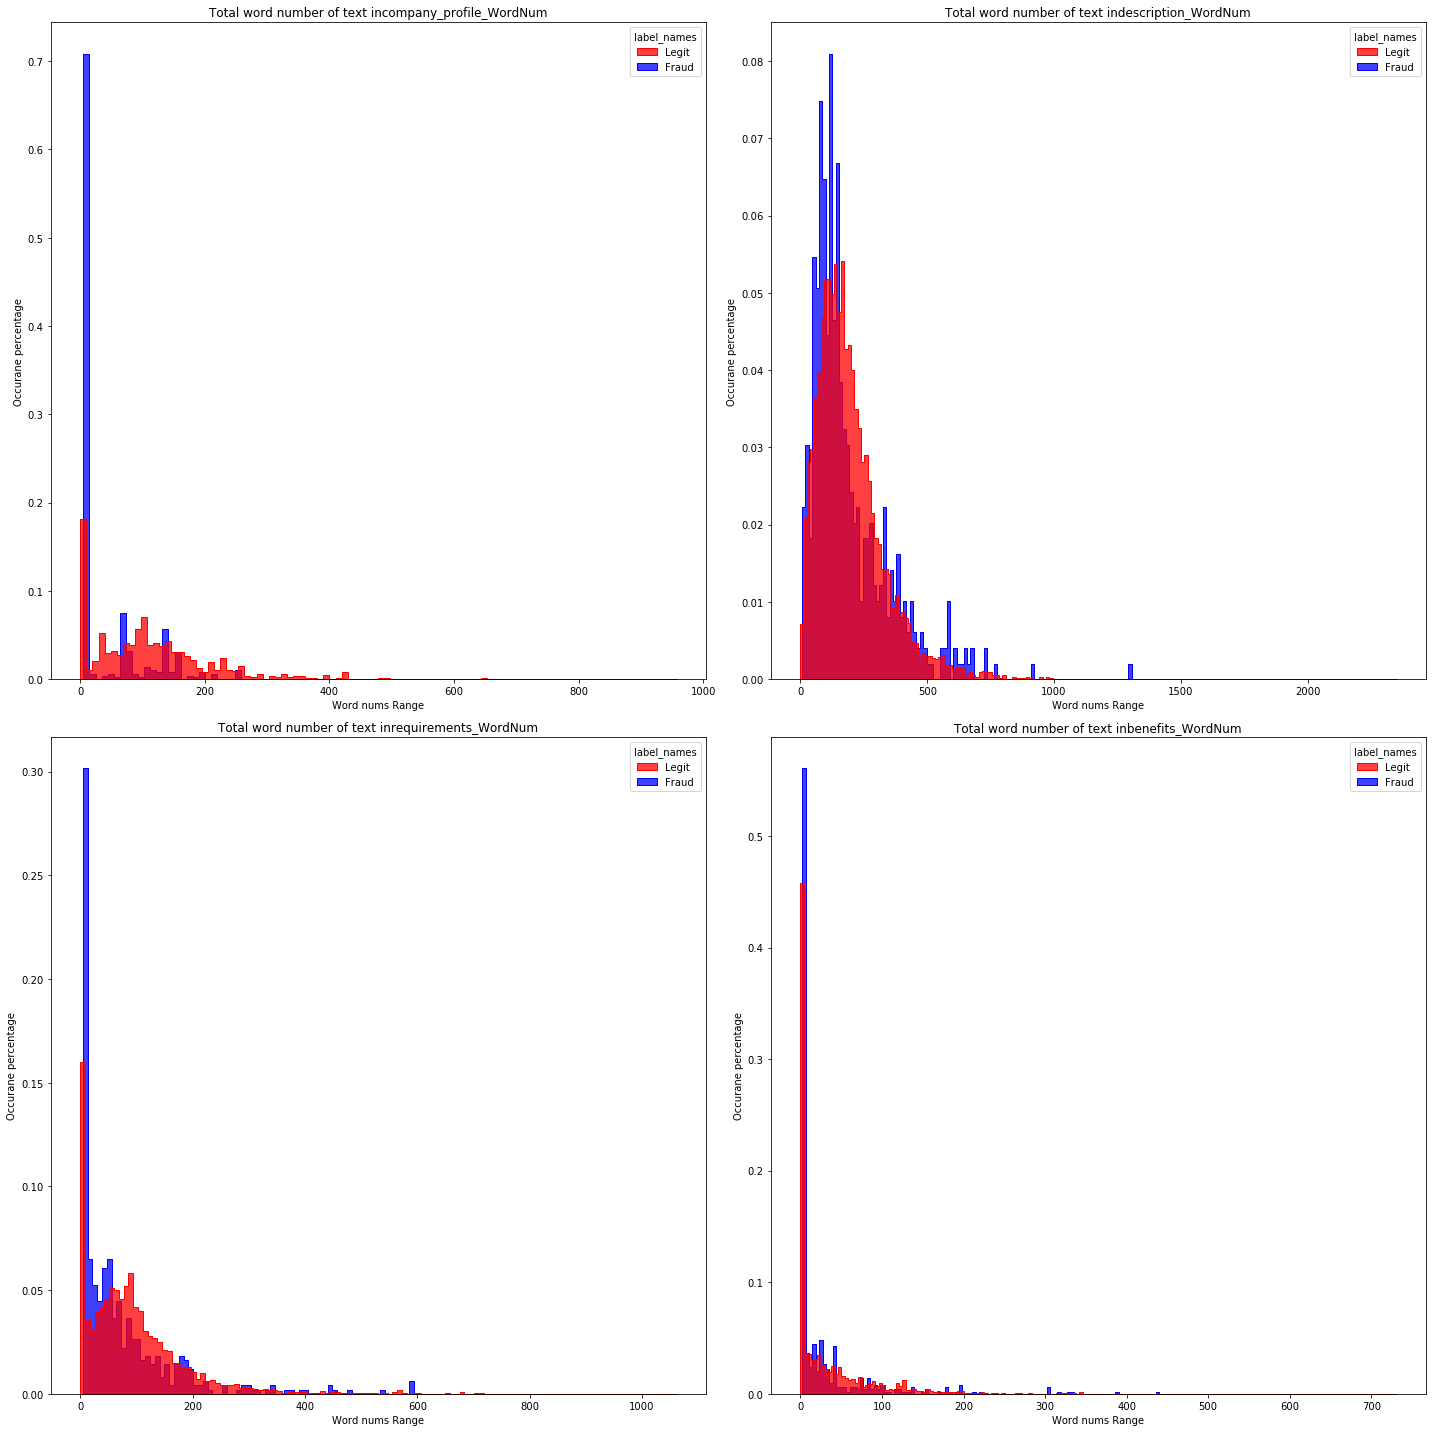

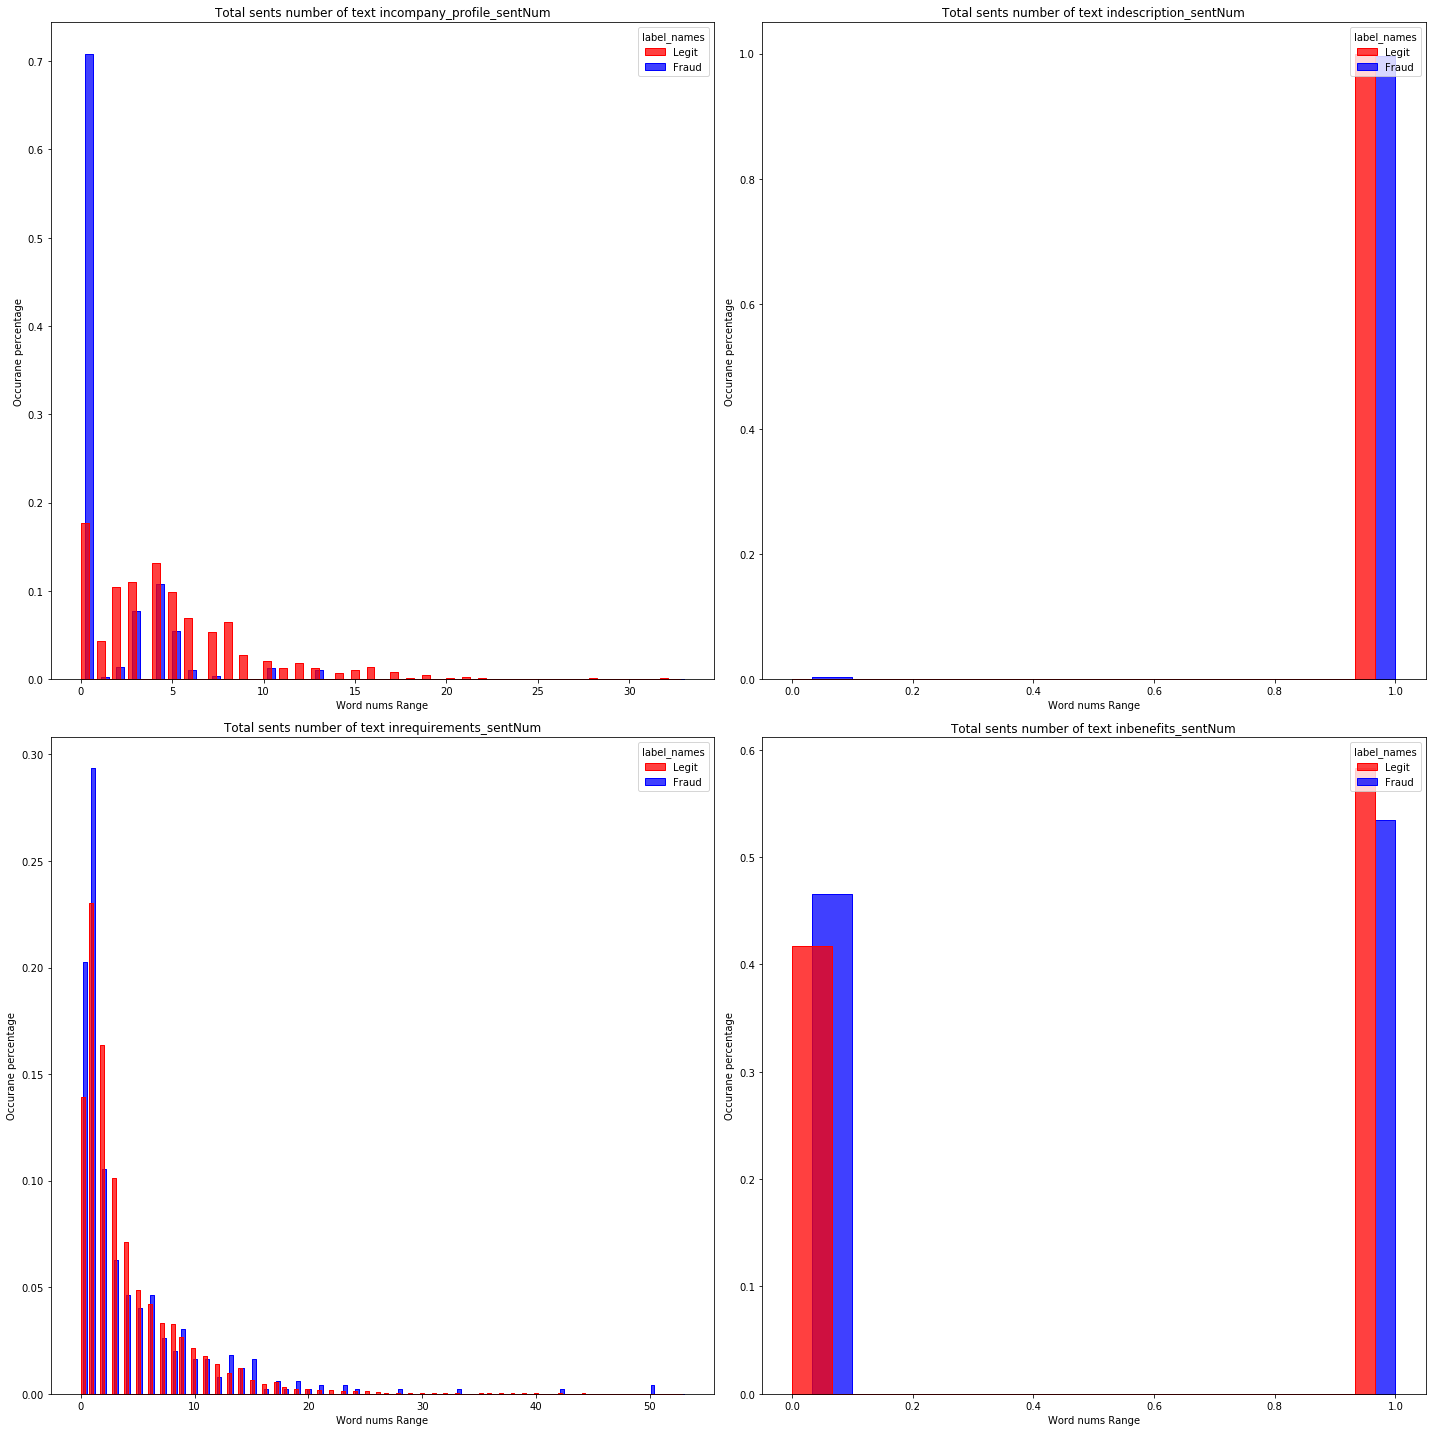

In [31]:
#display hitsogram bar plot for each wordNum columns(company_profile,job_description,requirement,benefit)
FreqHistPlot(df_text,[c_name+'_WordNum' for c_name in htmlCol_names],'Total word number of text in')
FreqHistPlot(df_text,[c_name+'_sentNum' for c_name in htmlCol_names],'Total sents number of text in')

In [32]:
#build model
# lemmatizer=WordNetLemmatizer()
path_to_model=r'D:\acer\Desktop\ORF_detect\saved_model\process_model\stanford-postagger-full-2020-11-17\models\english-bidirectional-distsim.tagger'
path_to_jar=r'D:\acer\Desktop\ORF_detect\saved_model\process_model\stanford-postagger-full-2020-11-17\stanford-postagger.jar'
pos_tagger=StanfordPOSTagger(path_to_model,path_to_jar)
# #modified  maximum heap size for java appilcation
pos_tagger.java_options='-Xmx7168m'
# stopwords=en_stopwords
def get_commonW(corpus):
    #using stanford model to pos tagging
    # list(list of list(tuple()))
    pos_corpus=[pos_tagger.tag_sents(text) for text in corpus]
    print('Pos tagging have already done,Next process is lemmatize and remove stopwords ...')
    #lemmatization word token
    pos_corpus=[[lemmatize_word(sent,lemmatizer) for sent in text] for text in pos_corpus]
    print('lemmatize have already done,Next process is count word freq ...')
    #compute word freq
    w_freq=Counter([w[0].lower() for text in pos_corpus for sent in text for w in sent \
                   if (w[0].lower() not in stopwords) and (w[0].lower() not in string.punctuation)])
    
    return w_freq


In [33]:
#Count word Freq in each column(profile,description,requirement,benefit)
# common_wordlist=[]
for c_name in htmlCol_names:
    fraud_df[c_name+'_posNum']=fraud_df[c_name+'_doc'].apply(lambda x:len([t.pos_ for t in x 
                                                                        if t.pos_.startswith(('J','RB'))]))
    print('Fraud pos tagger already completed!')
    legit_df[c_name+'_posNum']=legit_df[c_name+'_doc'].apply(lambda x:len([t.pos_ for t in x
                                                                        if t.pos_.startswith(('J','RB'))]))


Fraud pos tagger already completed!
Fraud pos tagger already completed!
Fraud pos tagger already completed!
Fraud pos tagger already completed!


In [45]:
# print(fraud_df.loc[:,'description_clean'].values.tolist())
result=legit_df.loc[:,'description_clean'].values.tolist()[0]
with en_nlp.disable_pipes('ner'):
    doc=en_nlp(result)



['Were on a mission to identify a smart and engaging FrontEnd Developer to join our clients engineering team.We know you are picky about finding the right role this is more than just a job, right?.Youre experienced, but you also like to learn new things and want to work with smart people and have fun building something great.Youll join a talented group of technical pros who try to maintain a friendly environment where people can be creative and get work done!Technology stack is Java/Agile/Scrum for web application and mobile development.For serious consideration, please provide a link to some sort of online portfolio or presence.DaytoDayDive into difficult problems and successfully deliver results within a scheduleWork with the product and design team to understand enduser requirements and usecases, then translate that into a pragmatic and effective technical solutionProblemsolving skills to debug issuesFind proactive innovative solutions for business challenges']


In [35]:
def plot_radarChart(y_values,y_ticks,markers,lineStyles,colors,labels,x_ticklabels,title)
    #build figure 
    plt.figure(figsize=(12,10))
    for y,m,c,l,ls in zip(y_values,markers,colors,labels,lineStyles):
        y=np.concatenate((y,y[:1]),axis=0)
        plt.polar(x_angles,y,ls=ls,color=c,marker=m,label=l)
    plt.xticks(x_angles[:-1],xtick_labels)
    plt.yticks(y_ticks,color='gray',size=10)
    plt.title(title)
    plt.legend()
    plt.show()


SyntaxError: invalid syntax (<ipython-input-35-3a978d1d639e>, line 1)

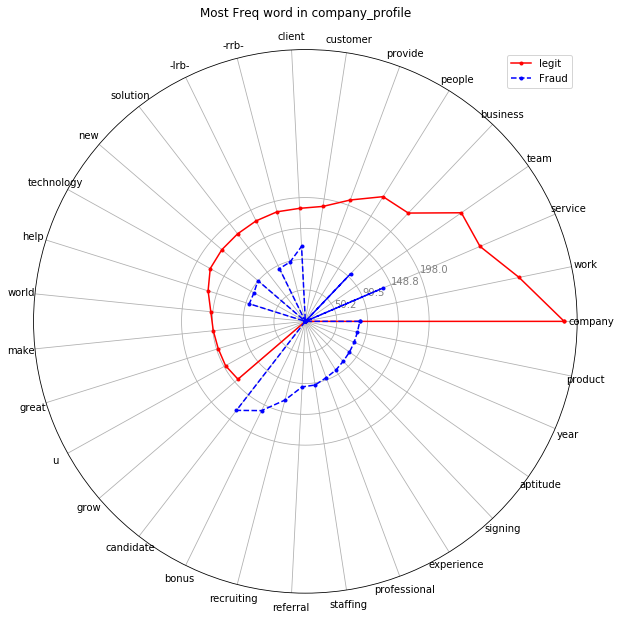

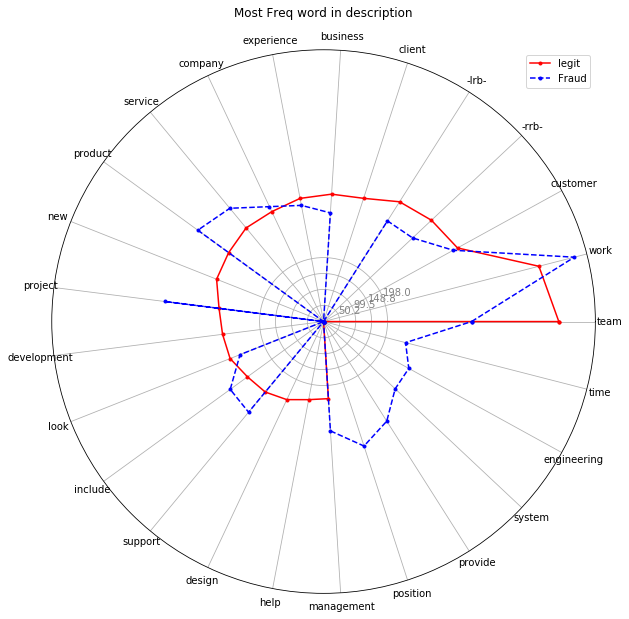

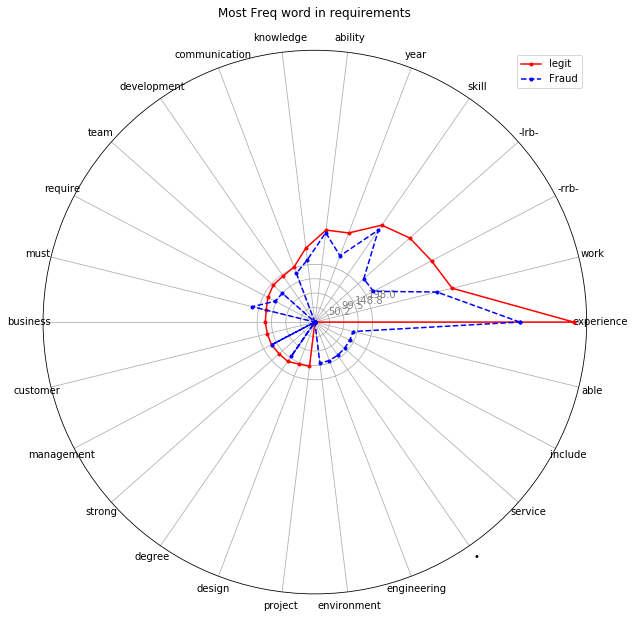

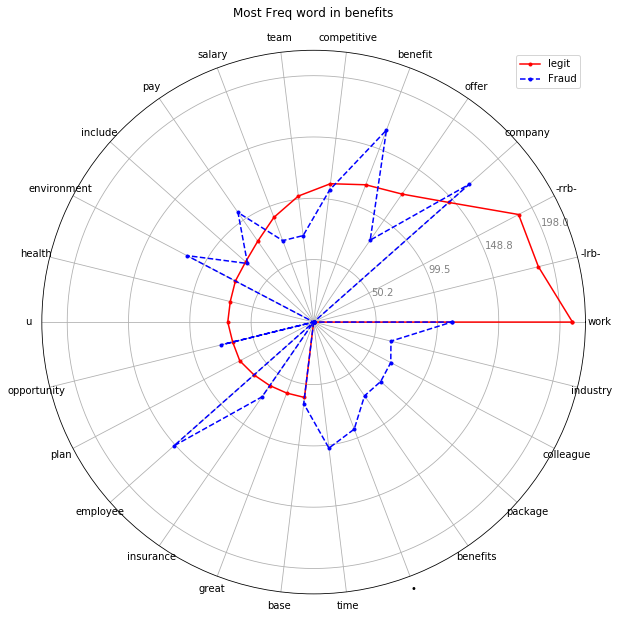

In [31]:
# for c_name,common_word in zip(htmlCol_names,common_wordlist):
#     #compute total words num
#     legit_totalNum=len(common_word[0].elements())
#     fraud_totalNum=len(common_word[1].elements())

#     #create x_labels
#     legit_common=dict(common_word[0].most_common(20))
#     fraud_common=dict(common_word[1].most_common(20))
#     x_ticklabels=list(legit_common.keys())+[w for w in fraud_common.keys() if w not in legit_common.keys()]
#     #create y_labels
#     y_fraud=np.array([int(fraud_common.get(w,0))/fraud_totalNum for w in x_ticklabels])
#     y_legit=np.array([int(legit_common.get(w,0))/legit_totalNum for w in x_ticklabels])

#     y_ticks=[0.2,0.4,0.6,0.8]
#     y_values=[y_legit,y_fraud]
#     markers=['.','.']
#     colors=['r','b']
#     labels=['legit','Fraud']
#     lineStyles=['-','--']
#     title=f'Most Freq word in {c_name}'
#     plot_radarChart(y_values,y_ticks,markers,lineStyles,colors,labels,x_ticklabels,title)